<a href="https://colab.research.google.com/github/THESHADOW2030/tweetsDisaster/blob/main/bigDataProject_DisasterClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuration Stuff

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=20768e7f6dfe0361c542c5b9d861ec03fa4b30eedadf87fc7ebffaa4556b9d69
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

###Some libraries that may be useful

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.linalg import VectorUDT, Vectors

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

###Spark configuration

In [3]:
                         
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:

sc._conf.getAll()

[('spark.app.name', 'PySparkTutorial'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.driver.port', '39689'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.

#Data Loading

In [6]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = "/content/drive/MyDrive/bigData/train.csv"
%cd /content/drive/MyDrive/bigData/

Mounted at /content/drive
/content/drive/MyDrive/bigData


In [7]:
df = spark.read.load('/content/drive/MyDrive/bigData/train.csv', format="csv", inferSchema="true", header="true")


In [8]:
df.show(5, truncate=False)

+---+-------+--------+-------------------------------------------------------------------------------------------------------------------------------------+------+
|id |keyword|location|text                                                                                                                                 |target|
+---+-------+--------+-------------------------------------------------------------------------------------------------------------------------------------+------+
|1  |null   |null    |Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                |1     |
|4  |null   |null    |Forest fire near La Ronge Sask. Canada                                                                                               |1     |
|5  |null   |null    |All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected|1     |
|6  |null   |nul

In [9]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



In [10]:
columnToDrop = ['keyword', 'location']
df = df.drop(*columnToDrop)

###Show 5 disaster tweets and 5 non disaster tweets

In [11]:
disTweets = df.filter(col("target") == 1)
regTweets = df.filter(col("target") == 0)



In [12]:
disTweets.show(5, truncate=False)
regTweets.show(5, truncate=False)

+---+-------------------------------------------------------------------------------------------------------------------------------------+------+
|id |text                                                                                                                                 |target|
+---+-------------------------------------------------------------------------------------------------------------------------------------+------+
|1  |Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                |1     |
|4  |Forest fire near La Ronge Sask. Canada                                                                                               |1     |
|5  |All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected|1     |
|6  |13,000 people receive #wildfires evacuation orders in California                                                 

There are 4095 tweets that are NOT abount a disaster before balancing
There are 3081 tweets about a disaster before balancing


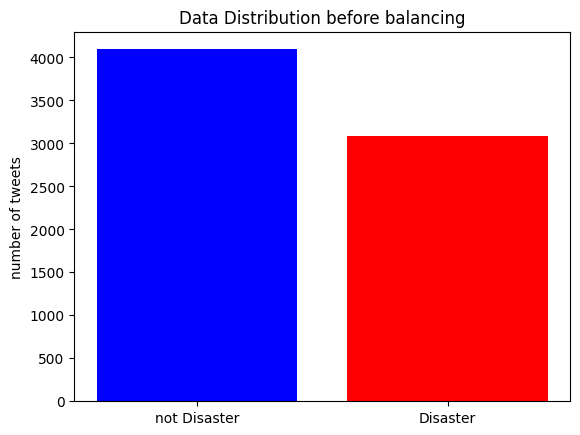

In [13]:
print(f"There are {regTweets.count()} tweets that are NOT abount a disaster before balancing")
print(f"There are {disTweets.count()} tweets about a disaster before balancing")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [regTweets.count(), disTweets.count()]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution before balancing')
plt.show()

As we can see from these numbers, this is an unbalanced dataset. There are 32% more disaster tweets than the regular ones. In order to overcome this problem I'll use a technique called **Under Sampling**. It involves randomly removing instances from the majority class to match the number of instances in the minority class

In [14]:
regTweets = regTweets.select('*').orderBy(rand())
regTweets = regTweets.limit(disTweets.count())


There are 3081 tweets that are NOT abount a disaster after balancing
There are 3081 tweets about a disaster after balancing


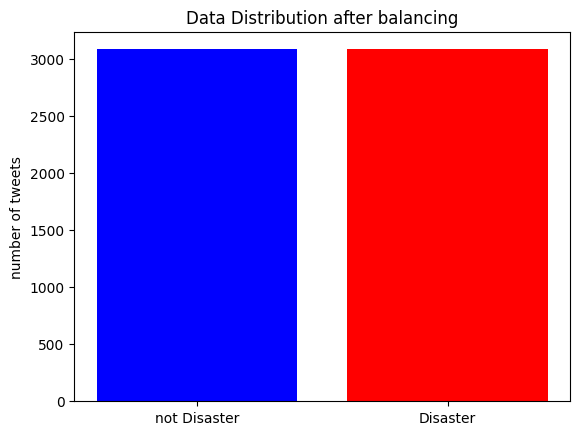

In [15]:
print(f"There are {regTweets.count()} tweets that are NOT abount a disaster after balancing")
print(f"There are {disTweets.count()} tweets about a disaster after balancing")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [disTweets.count(), regTweets.count()]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution after balancing')
plt.show()

Let us unite them again

In [16]:
tweets = regTweets.union(disTweets)

#Data Preprocessing

In [17]:
def clean_text(df, column_name="text"):
    """ 
    This function takes the raw text data and apply a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `cleaned_content` column as the results of the NLP preprocessing pipeline

    """
    from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    from nltk.stem.snowball import SnowballStemmer

    # Text preprocessing pipeline
    #print("***** Text Preprocessing Pipeline *****\n")

    # 1. Text cleaning
    #print("# 1. Text Cleaning\n")
    # 1.a Case normalization
    #print("1.a Case normalization:")
    lower_case_news_df = df.select("id", lower(col(column_name)).alias(column_name), "target")
    #lower_case_news_df.show(10)
    # 1.b Trimming
    #print("1.b Trimming:")
    trimmed_news_df = lower_case_news_df.select("id", trim(col(column_name)).alias(column_name), "target")
    #trimmed_news_df.show(10)
    # 1.c Filter out punctuation symbols
    #print("1.c Filter out punctuation:")
    no_punct_news_df = trimmed_news_df.select("id", (regexp_replace(col(column_name), "[^a-zA-Z\s]", "")).alias(column_name), "target")
    #no_punct_news_df.show(10)
    # 1.d Filter out any internal extra whitespace
    #print("1.d Filter out extra whitespaces:")
    cleaned_news_df = no_punct_news_df.select("id", trim(regexp_replace(col(column_name), " +", " ")).alias(column_name), "target")
    #cleaned_news_df.show(10)

    # 2. Tokenization (split text into tokens)
    #print("# 2. Tokenization:")
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_news_df)
    #tokens_df.show(10)

    # 3. Stopwords removal
    #print("# 3. Stopwords removal:")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)
    #terms_df.show(10)

    # 4. Stemming (Snowball stemmer)
    #print("# 4. Stemming:")
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))
    #terms_stemmed_df.show(10)
    
    return terms_stemmed_df

In [18]:
tweets_preProcessed = clean_text(tweets)
columnToDrop = ['id', 'text', 'tokens', 'terms']
tweets_preProcessed = tweets_preProcessed.drop(*columnToDrop)
tweets_preProcessed.show(5, truncate = False)



+------+--------------------------------------------------------------------------------------------------+
|target|terms_stemmed                                                                                     |
+------+--------------------------------------------------------------------------------------------------+
|0     |[im, experienc, injuri, waist]                                                                    |
|0     |[egan, arent, mani, obliter, server, alway, like, play, d]                                        |
|0     |[season, new, girl, emot, train, wreck, want, cri, laugh, eat, lot, ice, cream]                   |
|0     |[xbox, pro, consol, red, ring, death, full, read, ebay, httptcogktshiorr, httptcojeuukoi]         |
|0     |[your, slate, gpaulista, jackwilsher, injuri, your, disgrac, afc, fan, base, injuri, happen, cunt]|
+------+--------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [19]:
import gensim.downloader as api
import gensim
downloadModel = True
numberOfEmbeddings = 100 #25 50 100 200

In [20]:
#modelPath = './word2vec-google-news-300'
if downloadModel:
  wv = api.load(f"glove-twitter-{numberOfEmbeddings}")
  #wv.save(modelPath)
  downloadModel = False

[=================================================-] 99.7% 385.8/387.1MB downloaded


Before, I was putting a vector of all zeros when I didn't get a hit in the glove model. This was adding sparsity. 
The embedding extractor was defined as:

 embeddingExtractor = udf(lambda tokens: [[float(x) for x in wv[token]] if token in wv else [float(0.0)]*wv["king"].shape[0] for token in tokens], ArrayType((ArrayType(FloatType()))))

In [21]:
#embeddingExtractor = udf(lambda tokens: [[float(x) for x in wv[token]] for token in tokens  if token in wv ], ArrayType((ArrayType(FloatType()))))


embeddingExtractor = udf(lambda tokens: [[float(x) for x in wv[token]] if token in wv else [float(0.0)]*wv["king"].shape[0] for token in tokens], ArrayType((ArrayType(FloatType()))))

avgEmbedding = udf(lambda x :[float(y) for y in np.mean(x, axis = 0)])

In [22]:
tweets_withEmbedding = tweets_preProcessed.withColumn("wordsEmbedding", embeddingExtractor("terms_stemmed"))
tweets_withEmbedding = tweets_withEmbedding.withColumn("tweetEmbedding", avgEmbedding("wordsEmbedding"))
tweets_withEmbedding.show(5, truncate = False)

+------+--------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Since pySpark does not support ArrayType((ArrayType(FloatType()))) for its model, I need to convert it in a Vector Type

In [23]:

#Define a UDF to convert the arrays of floats into dense vectors
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

#Apply the UDF to transform the "tweetEmbedding" column
tweets_withEmbedding = tweets_withEmbedding.withColumn("tweetEmbedding", array_to_vector_udf(tweets_withEmbedding["tweetEmbedding"]))

columnToDrop = ['wordsEmbedding']
tweets_withEmbedding = tweets_withEmbedding.drop(*columnToDrop)




In [24]:
#@title data visualizzation
tweets_withEmbedding.show(5, truncate = False)
for column_name, column_type in tweets_withEmbedding.dtypes:
    print(f"Column '{column_name}' has data type: {column_type}")

+------+--------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Fun Part
Here comes the fun part. In this section, will perform some tecquiniques in order to visualize better the data (using PCA in order to plot it) and machine learning algortithms (SVC; logistic regression)

##PCA

In [25]:
from pyspark.ml.feature import PCA
K = 10
pca_model = PCA(k=K, inputCol="tweetEmbedding", outputCol="pca_features")
pca_features = pca_model.fit(tweets_withEmbedding)
pca_tweets_df = pca_features.transform(tweets_withEmbedding).cache()
     

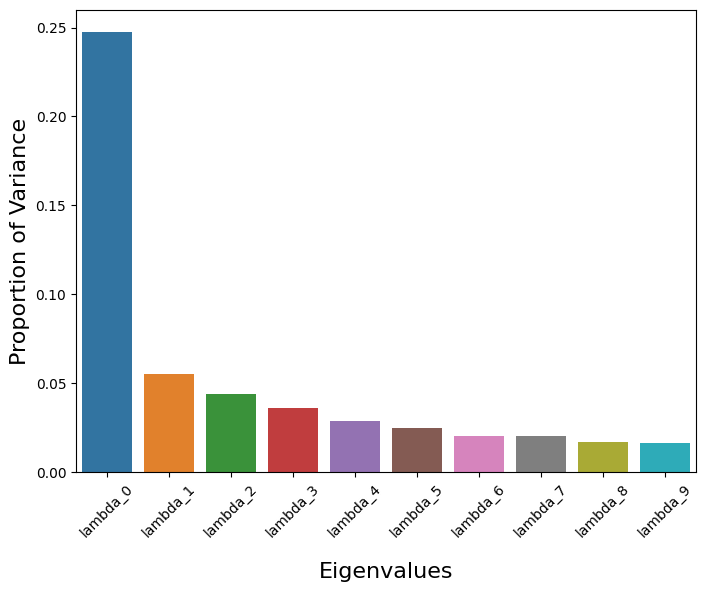

In [26]:
#@title Variance distribution
fig, ax = plt.subplots(1,1,figsize=(8,6))
_ = sns.barplot(x=[i for i in range(K)], 
                y=pca_features.explainedVariance.values, # `explainedVariance` returns the distribution of variance across eigenvectors, i.e., lambda_i/sum lambda_i
                ax=ax)
_ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
_ = ax.set_ylabel("Proportion of Variance", fontsize=16)
_ = ax.set_xticklabels(["lambda_{:d}".format(i) for i in range(K)], rotation=45)

In [27]:
#@title from pySpark dataframe to pandas dataframe
pca_tweets_pdf = pca_tweets_df.toPandas()

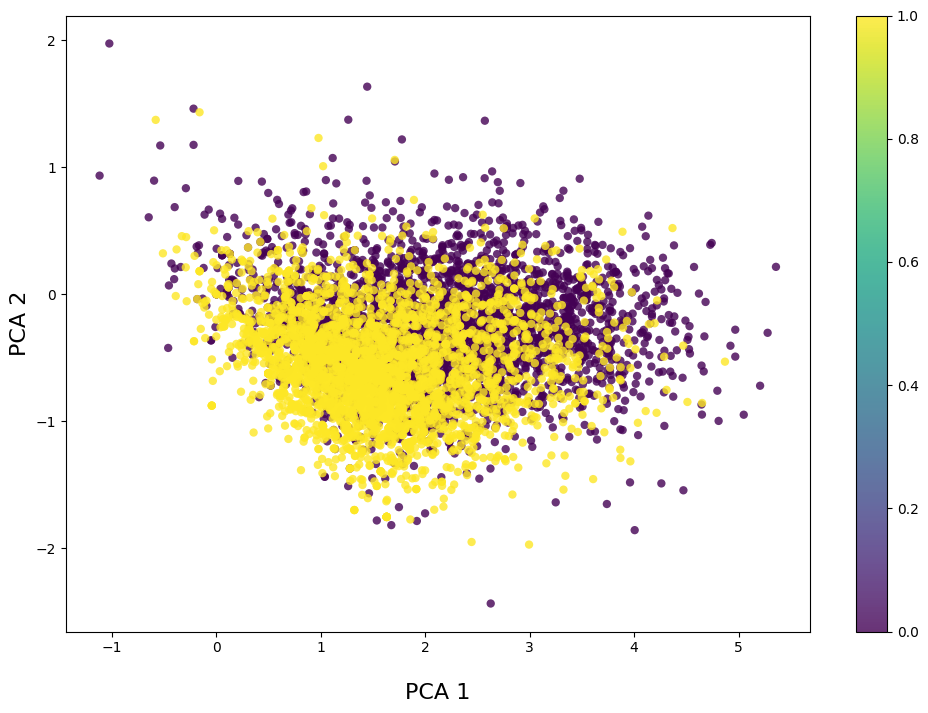

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
_ = plt.scatter(
    pca_tweets_pdf.pca_features.map(lambda x: x[0]), 
    pca_tweets_pdf.pca_features.map(lambda x: x[1]),
    c=pca_tweets_pdf.target, 
    edgecolor='none', 
    alpha=0.8,
    axes=ax
    )
_ = ax.set_xlabel('PCA 1', labelpad=20, fontsize = 16)
_ = ax.set_ylabel('PCA 2', fontsize = 16)
plt.colorbar();

##Machine Learning

Now that we visualized the data and did some exploratiom, we can try to capture some patterns by applying machine learning techniques.


Lets take a look again at our dataframe

In [29]:
#@title data visualizzation
tweets_withEmbedding = tweets_withEmbedding.select('*').orderBy(rand())
tweets_withEmbedding.show(5, truncate = False)


+------+----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
#@title test-train split
train_df, test_df = tweets_withEmbedding.randomSplit([0.8, 0.2], seed = 42)



In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction")

There are 2515 tweets that are NOT abount a disaster after balancing
There are 2484 tweets about a disaster after balancing


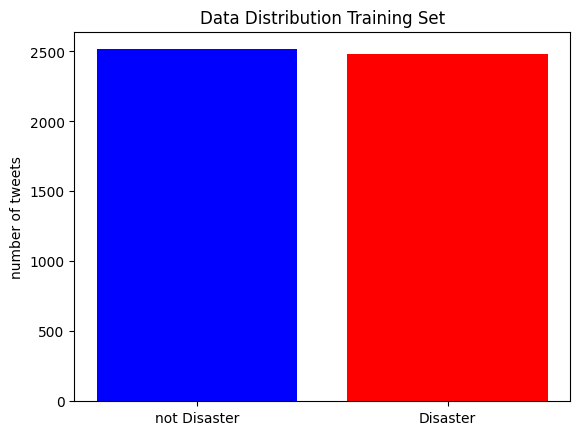

In [32]:
#df.filter(col("target") == 0)
nRegTrain = train_df.filter(col("target") == 0).count()
nDisTrain = train_df.filter(col("target") == 1).count()

print(f"There are {nRegTrain} tweets that are NOT abount a disaster after balancing")
print(f"There are {nDisTrain} tweets about a disaster after balancing")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [nRegTrain, nDisTrain]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution Training Set')
plt.show()

There are 2515 tweets that are NOT abount a disaster after balancing
There are 2484 tweets about a disaster after balancing


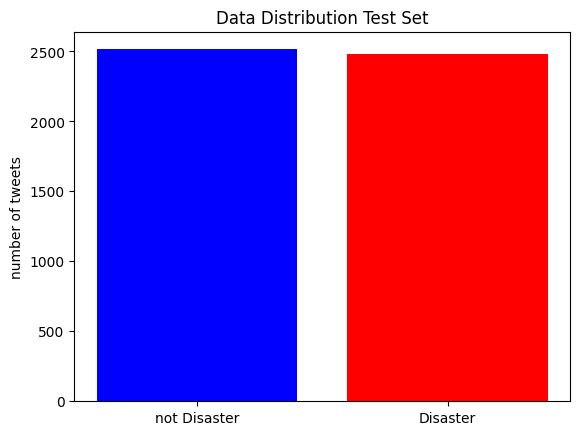

In [33]:
#df.filter(col("target") == 0)
nRegTest = test_df.filter(col("target") == 0).count()
nDisTest = test_df.filter(col("target") == 1).count()

print(f"There are {nRegTrain} tweets that are NOT abount a disaster after balancing")
print(f"There are {nDisTrain} tweets about a disaster after balancing")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [nRegTrain, nDisTrain]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution Test Set')
plt.show()

Great! Now that we have split the dataset in two sets: 
1.   Train set
2.   Test Set

Note: usually, I would create also a third split: the validation set. I didn't do it this time given the limited size of this dataset.



###Support Vector Classifier

In [34]:
from pyspark.ml.classification import LinearSVC
linSVC = LinearSVC(featuresCol = "tweetEmbedding", labelCol = "target", maxIter=1000)
linSVC_model = linSVC.fit(train_df)

In [35]:
# Get the training summary
summary = linSVC_model.summary()
print(summary.accuracy) #0.77

0.7743548709741949


In [37]:
linSVC_pred = linSVC_model.transform(test_df)
evaluator.evaluate(linSVC_pred)


0.7729193671537902

###Multiple Layer Perceptron

In [44]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

mlp = MultilayerPerceptronClassifier( layers=[100, 50, 10, 2], seed=42, 
                                      featuresCol = "tweetEmbedding", labelCol = "target",
                                      maxIter = 500)

mlp_model = mlp.fit(train_df)
mlp_model.summary().accuracy

0.9835967193438687

In [45]:
mlp_pred = mlp_model.transform(test_df)
evaluator.evaluate(mlp_pred)

0.7487008067427834

###Logistic Regression

In [46]:
from pyspark.ml.classification import LogisticRegression

logReg =  LogisticRegression( seed=42, 
                              featuresCol = "tweetEmbedding", labelCol = "target",
                              maxIter = 1000)


TypeError: ignored